In [1]:
from __future__ import print_function

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


def calibrate_camera(cal_images_path, cal_save_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(cal_images_path)

    draw_index = 0
    fig1 = plt.figure(1, figsize=(16, 9))
    image_size = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        if image_size == None:
            image_size = (img.shape[1], img.shape[0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            # show 4 of the Chessboard with drawed corner
            draw_index = draw_index + 1
            if draw_index <= 4:
                plt.subplot(2, 2, draw_index)
                plt.imshow(img)
                plt.title(fname)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
    # save the calibration paraeters
    cal_para = {}
    cal_para["mtx"] = mtx
    cal_para["dist"] = dist
    pickle.dump(cal_para, open(cal_save_path, "wb"))
    plt.show()

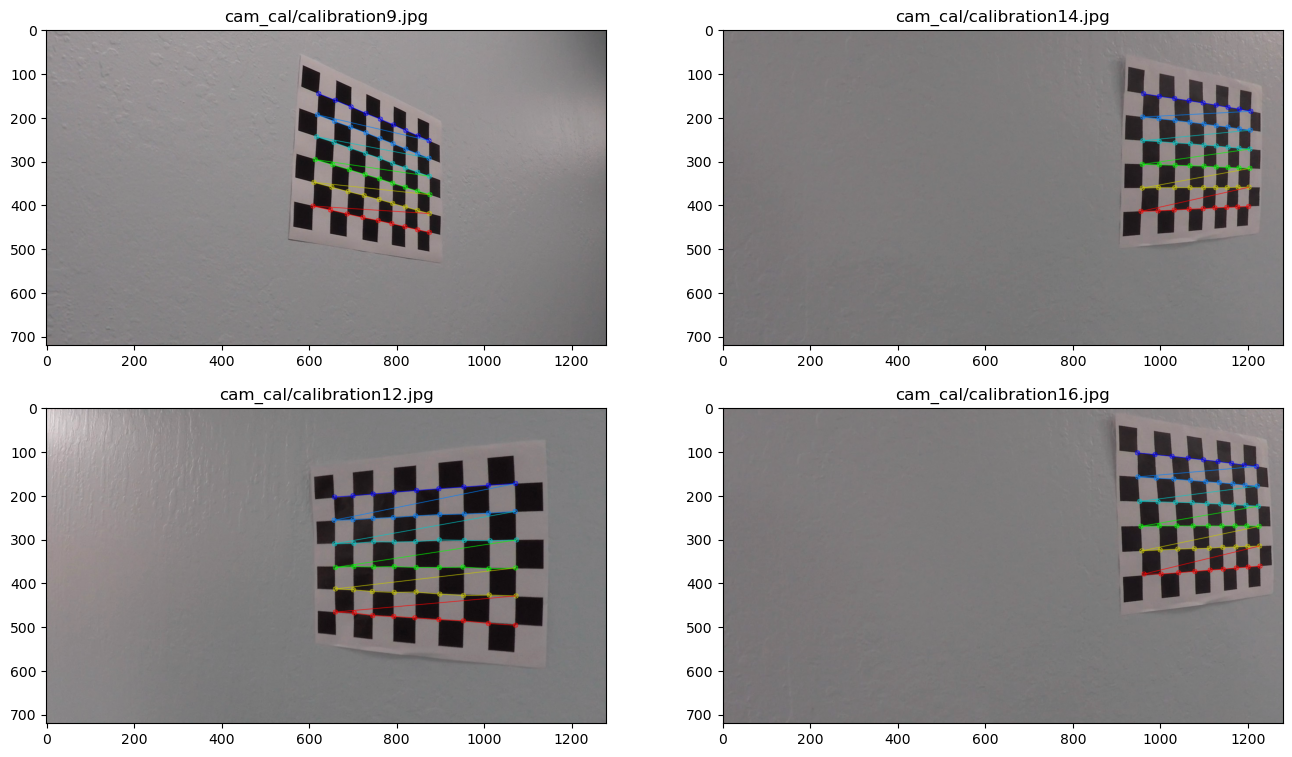

In [2]:
calibrate_camera('cam_cal/calibration*.jpg', 'calibration_paraeters.pkl')

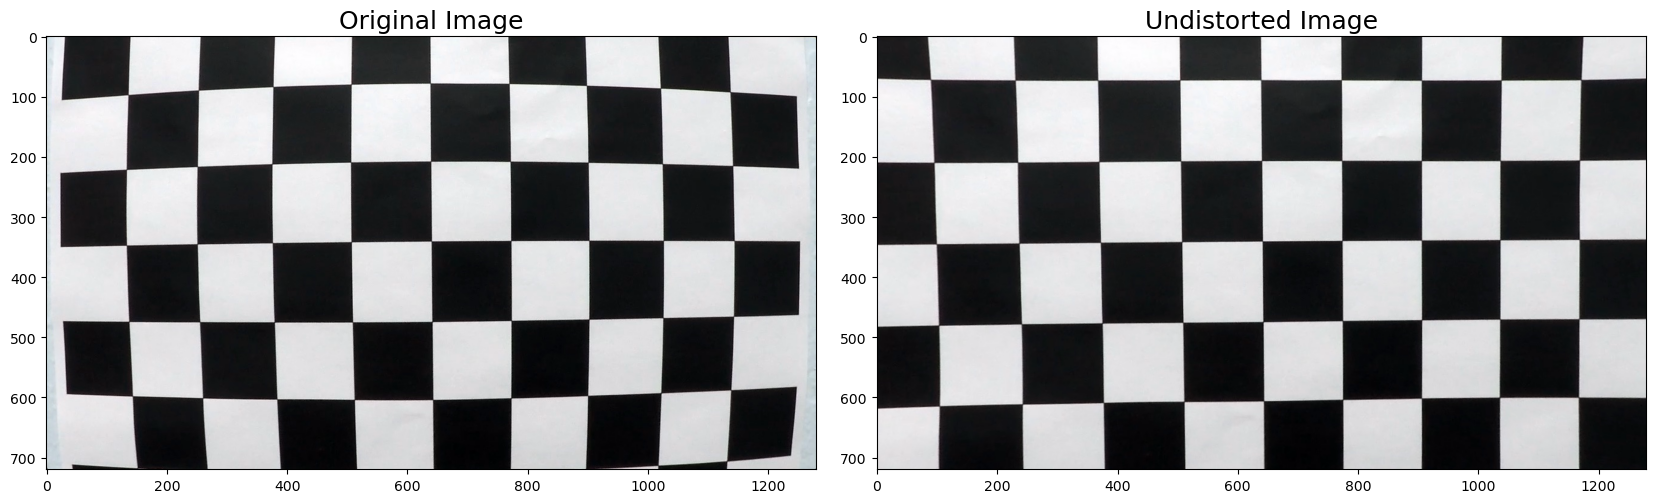

In [3]:
# image distortion correction and
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


# Read in an image
img = cv2.imread('cam_cal/calibration1.jpg')

with open('calibration_paraeters.pkl', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

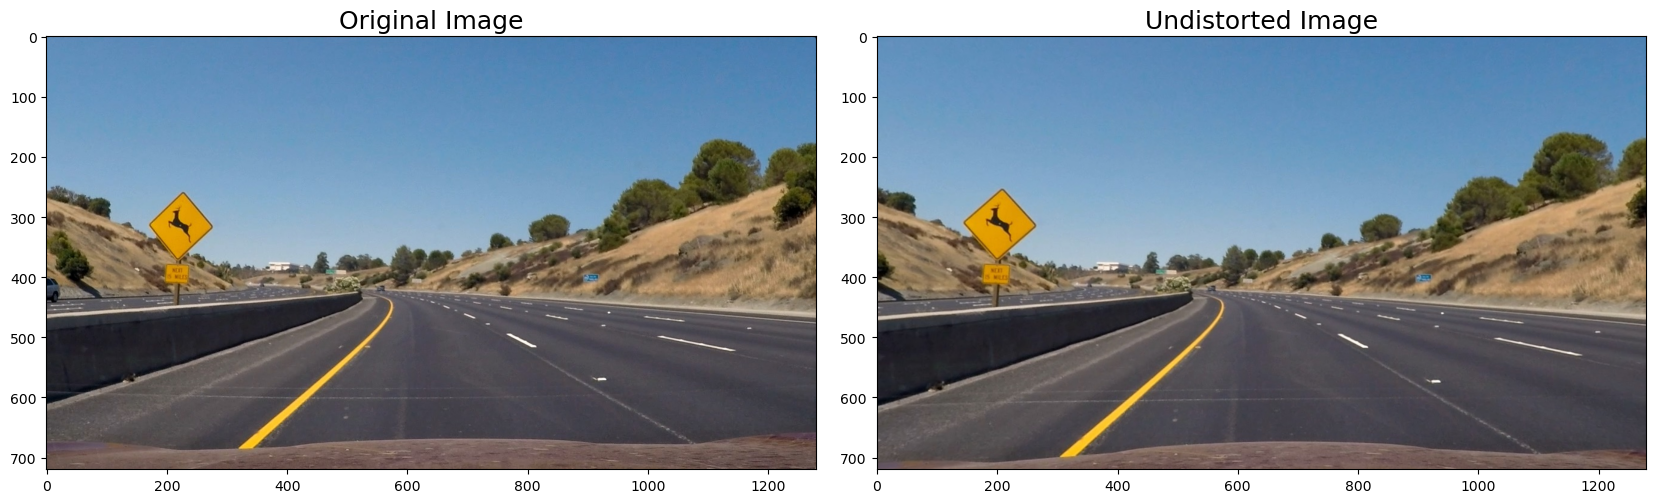

In [4]:
origin_img = cv2.imread('test_images/test2.jpg')
test_img = cal_undistort(origin_img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=18)
ax2.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

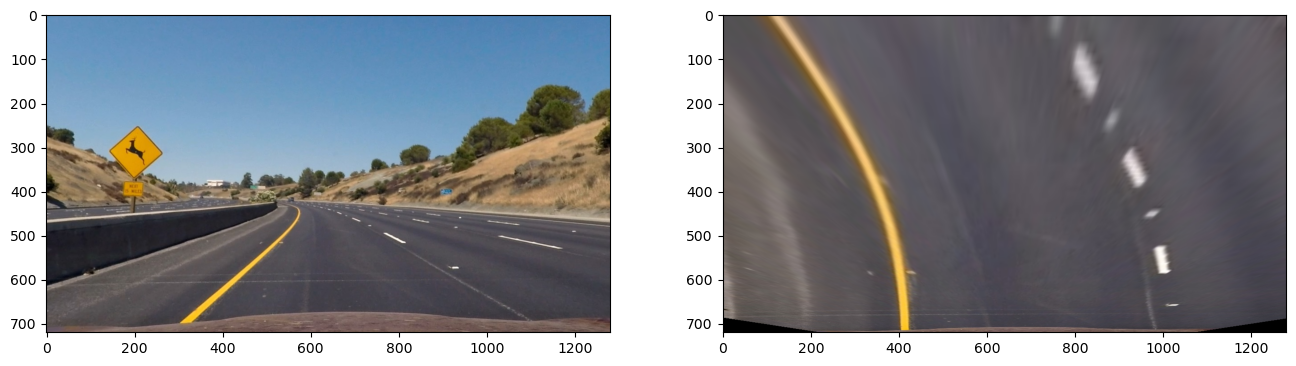

In [5]:
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

def perspective_transform(img, M):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

def subplot(rows, cols, imgs):
    nums = rows * cols
    fig = plt.figure(1, figsize=(16, 9))
    for i in range(1, nums+1):
        plt.subplot(rows, cols, i)
        plt.imshow(imgs[i-1])


# left_top to left_bottom,
corners = [(603, 445), (677, 445), (1105, 720), (205, 720)]

wrap_offset = 150
src_corners = [(603, 445), (677, 445), (1105, test_img.shape[0]), (205, test_img.shape[0])]
dst_corners = [(205 + wrap_offset, 0), (1105 - wrap_offset, 0), (1105 - wrap_offset, test_img.shape[0]), (205 + wrap_offset, test_img.shape[0])]
M = cv2.getPerspectiveTransform(np.float32(src_corners), np.float32(dst_corners))
wrap_img= perspective_transform(test_img, M)

subplot(1, 2, [test_img, wrap_img])

In [6]:
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

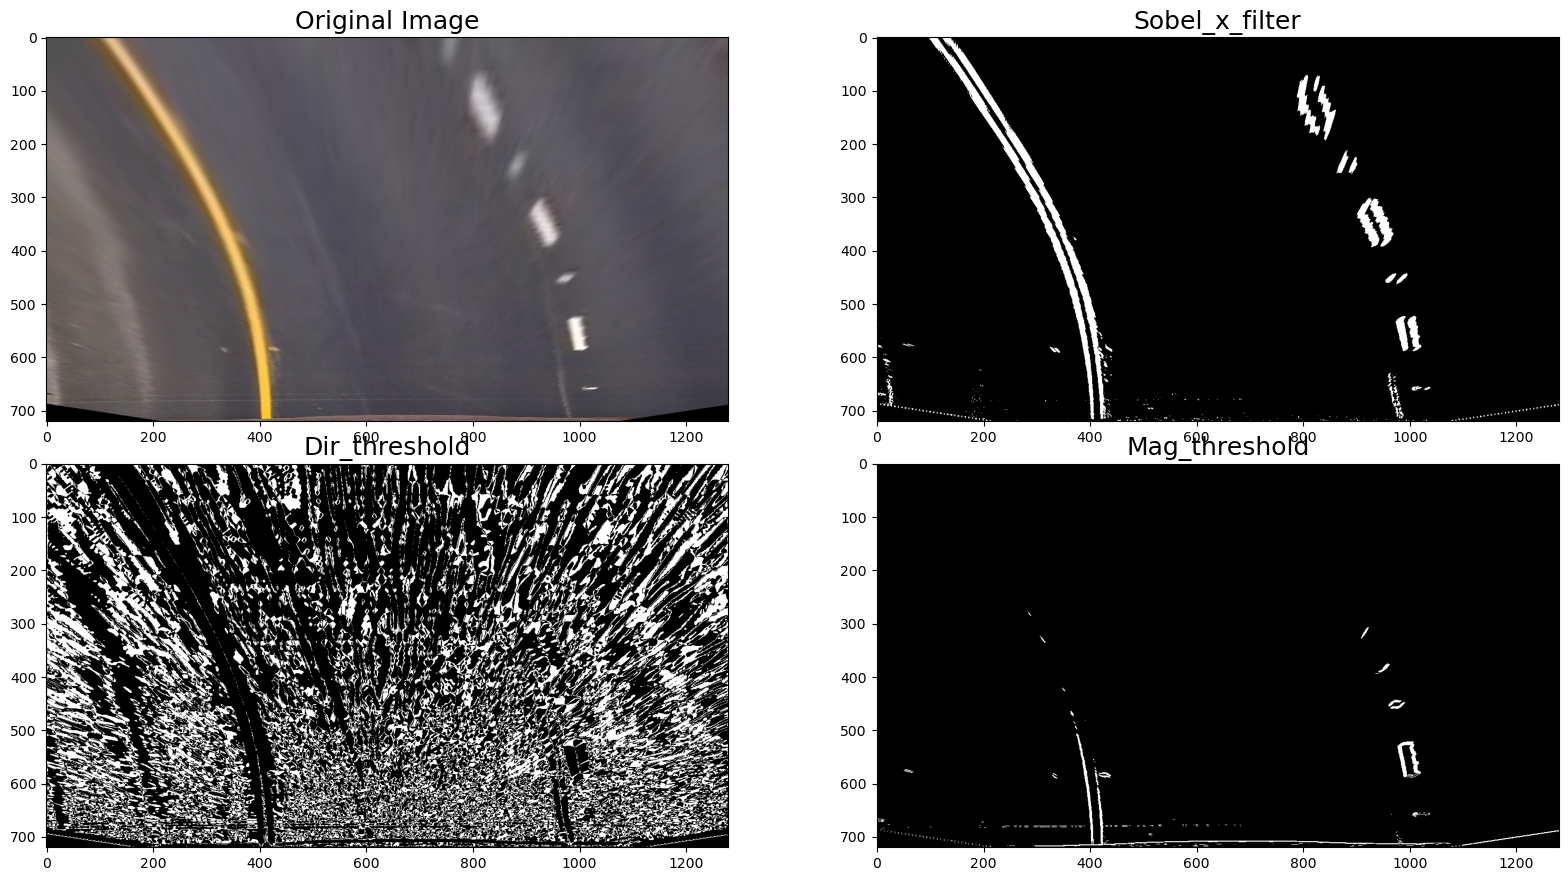

In [7]:
ksize = 9 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(wrap_img, orient='x', sobel_kernel=3, thresh=(20, 255))

mag_binary = mag_thresh(wrap_img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = dir_threshold(wrap_img, sobel_kernel=15, thresh=(0.7, 1.3))

# Plot the result
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(wrap_img)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(gradx, cmap='gray')
axs[0, 1].set_title('Sobel_x_filter', fontsize=18)
axs[1, 0].imshow(dir_binary, cmap='gray')
axs[1, 0].set_title('Dir_threshold', fontsize=18)
axs[1, 1].imshow(mag_binary, cmap='gray')
axs[1, 1].set_title('Mag_threshold', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [8]:
def r_select(img, thresh=(200, 255)):
    R = img[:,:,0]
    binary = np.zeros_like(R)
    binary[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary

def color_mask(hsv,low,high):
    # Return mask from HSV 
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv,img,low,high):
    # Apply color mask to image
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img,img, mask= mask)
    return res

def apply_yellow_white_mask(img):
    image_HSV = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    yellow_hsv_low  = np.array([ 0,  100,  100])
    yellow_hsv_high = np.array([ 80, 255, 255])
    white_hsv_low  = np.array([ 0,   0,   160])
    white_hsv_high = np.array([ 255,  80, 255])   
    mask_yellow = color_mask(image_HSV,yellow_hsv_low,yellow_hsv_high)
    mask_white = color_mask(image_HSV,white_hsv_low,white_hsv_high)
    mask_YW_image = cv2.bitwise_or(mask_yellow,mask_white)
    return mask_YW_image

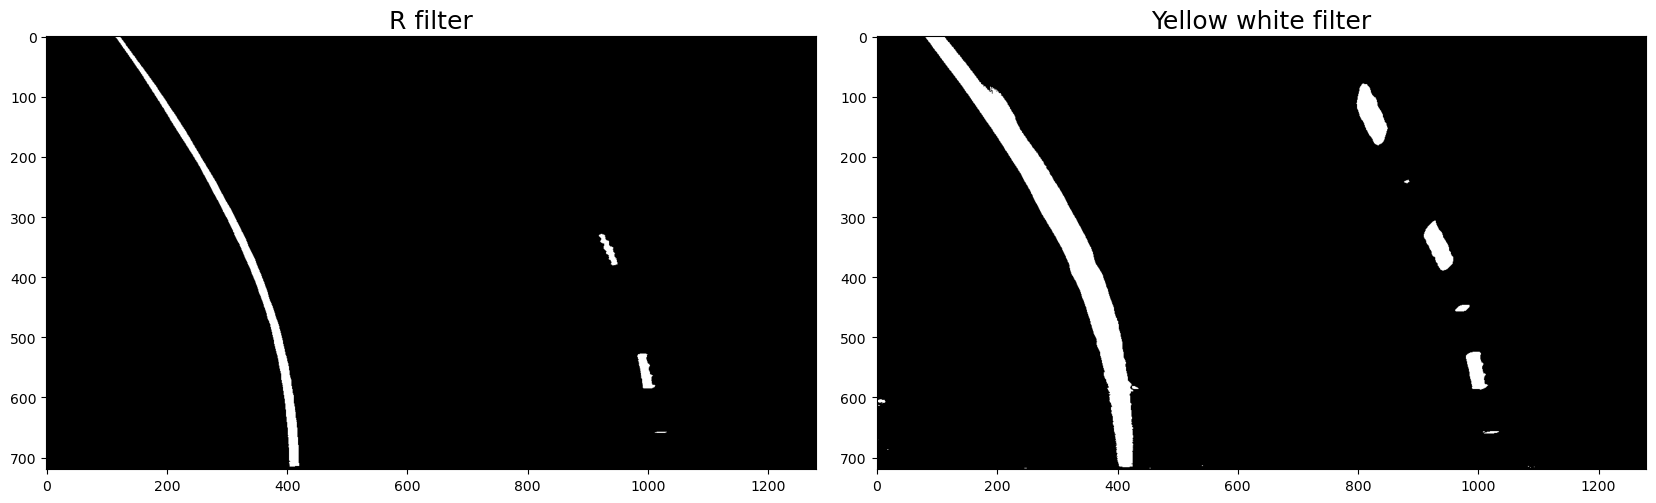

In [9]:
r_binary = r_select(wrap_img, thresh=(220, 255))
yw_binary = apply_yellow_white_mask(wrap_img)
# Plot the result
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(r_binary, cmap='gray')
axs[0].set_title('R filter', fontsize=18)
axs[1].imshow(yw_binary, cmap='gray')
axs[1].set_title('Yellow white filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [10]:
def hls_select(img, channel='S', thresh=(90, 255)):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 'S':
        X = hls[:, :, 2]
    elif channel == 'H':
        X = hls[:, :, 0]
    elif channel == 'L':
        X = hls[:, :, 1]
    else:
        print('illegal channel !!!')
        return
    binary_output = np.zeros_like(X)
    binary_output[(X > thresh[0]) & (X <= thresh[1])] = 1
    return binary_output

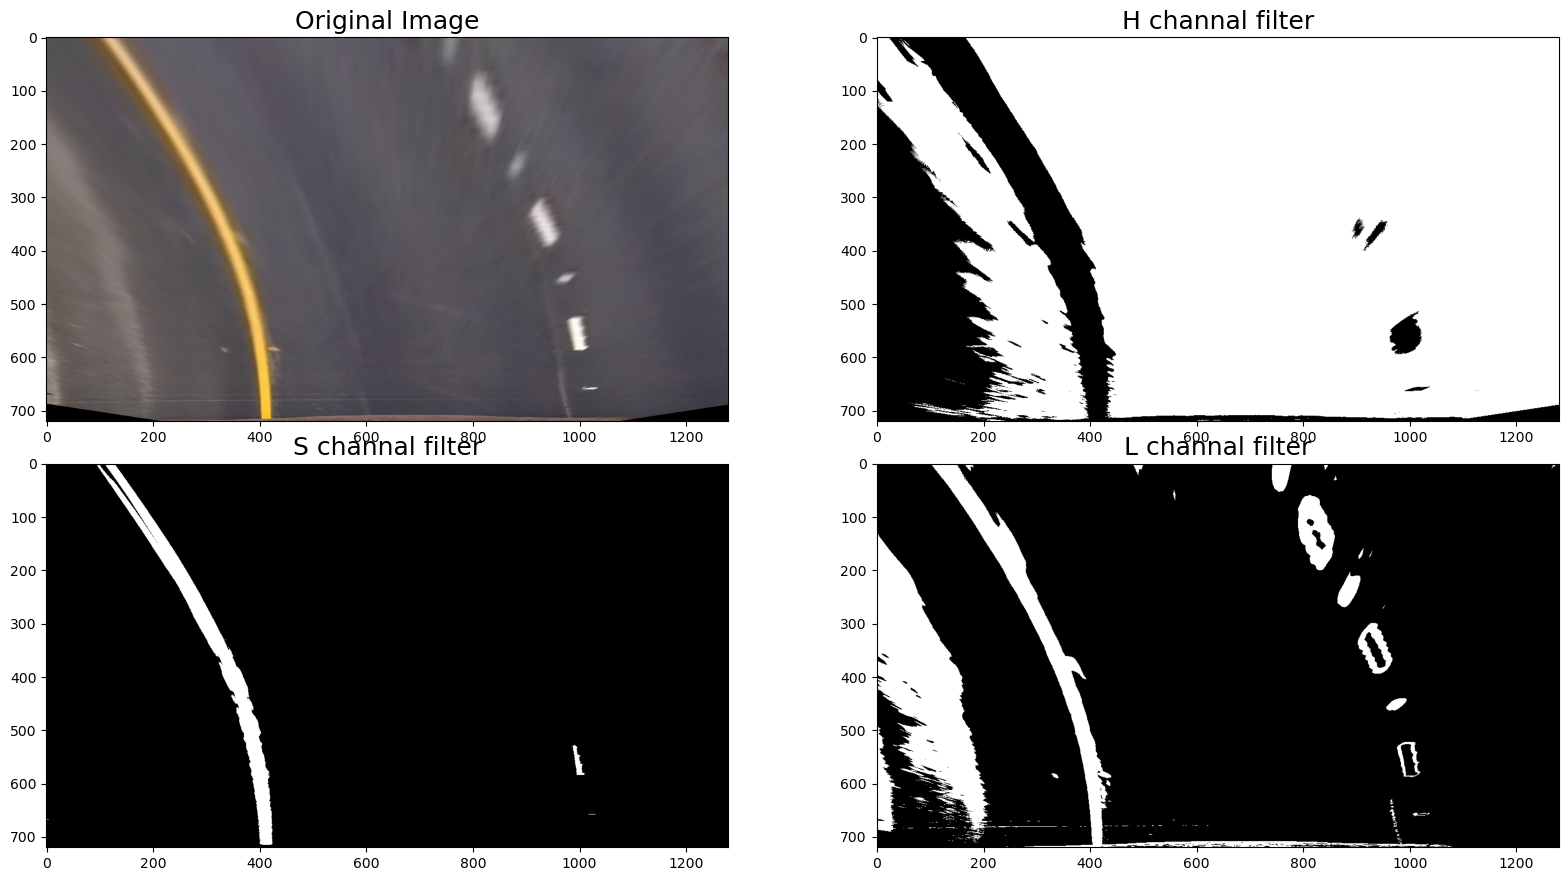

In [11]:
l_binary = hls_select(wrap_img, channel='L', thresh=(100, 200))
s_binary = hls_select(wrap_img, channel='S', thresh=(100, 255))
h_binary = hls_select(wrap_img, channel='H', thresh=(100, 255))
f, axs = plt.subplots(2, 2, figsize=(16, 9))
f.tight_layout()
axs[0, 0].imshow(wrap_img)
axs[0, 0].set_title('Original Image', fontsize=18)
axs[0, 1].imshow(h_binary, cmap='gray')
axs[0, 1].set_title('H channal filter', fontsize=18)
axs[1, 0].imshow(s_binary, cmap='gray')
axs[1, 0].set_title('S channal filter', fontsize=18)
axs[1, 1].imshow(l_binary, cmap='gray')
axs[1, 1].set_title('L channal filter', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [12]:
def combine_filters(img):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 255))
    l_binary = hls_select(img, channel='L', thresh=(100, 200))
    s_binary = hls_select(img, channel='S', thresh=(100, 255))
    yw_binary = apply_yellow_white_mask(wrap_img)
    yw_binary[(yw_binary !=0)] = 1
    combined_lsx = np.zeros_like(gradx)
    combined_lsx[((l_binary == 1) & (s_binary == 1) | (gradx == 1) | (yw_binary == 1))] = 1
    return combined_lsx

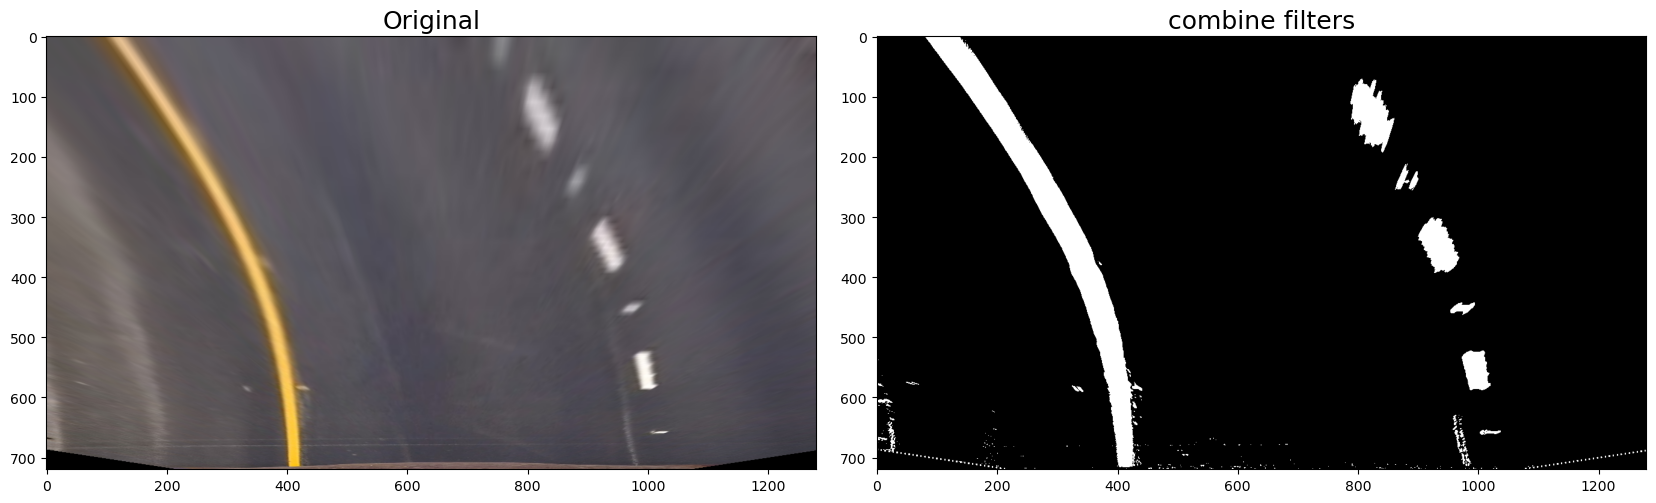

In [13]:
binary = combine_filters(wrap_img)
f, axs = plt.subplots(1, 2, figsize=(16, 9))
f.tight_layout()
axs[0].imshow(wrap_img)
axs[0].set_title('Original', fontsize=18)
axs[1].imshow(binary, cmap='gray')
axs[1].set_title('combine filters', fontsize=18)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [14]:
def find_line_fit(img, nwindows=9, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # to plot
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, out_img

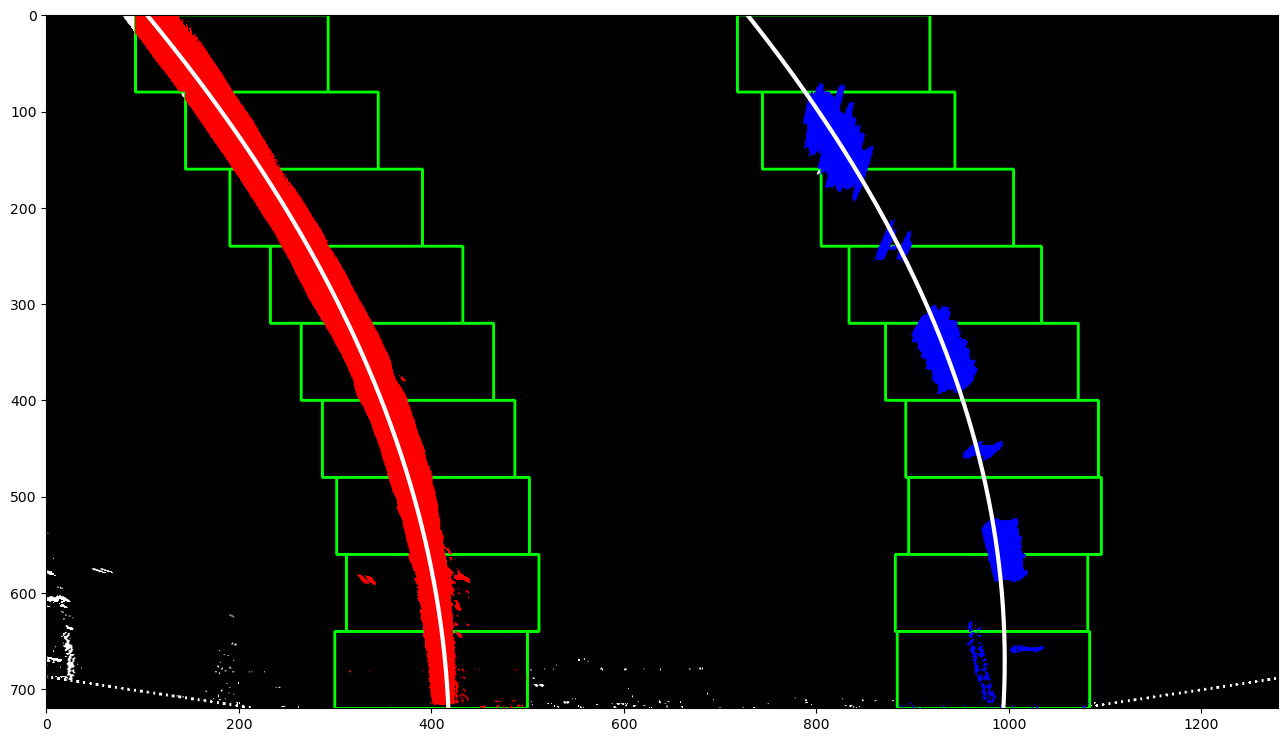

In [15]:
# Generate x and y values for plotting
def get_fit_xy(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx, right_fitx, ploty

left_fit, right_fit, out_img = find_line_fit(binary)
left_fitx, right_fitx, ploty = get_fit_xy(binary, left_fit, right_fit)

fig = plt.figure(figsize=(16, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='white', linewidth=3.0)
plt.plot(right_fitx, ploty, color='white',  linewidth=3.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

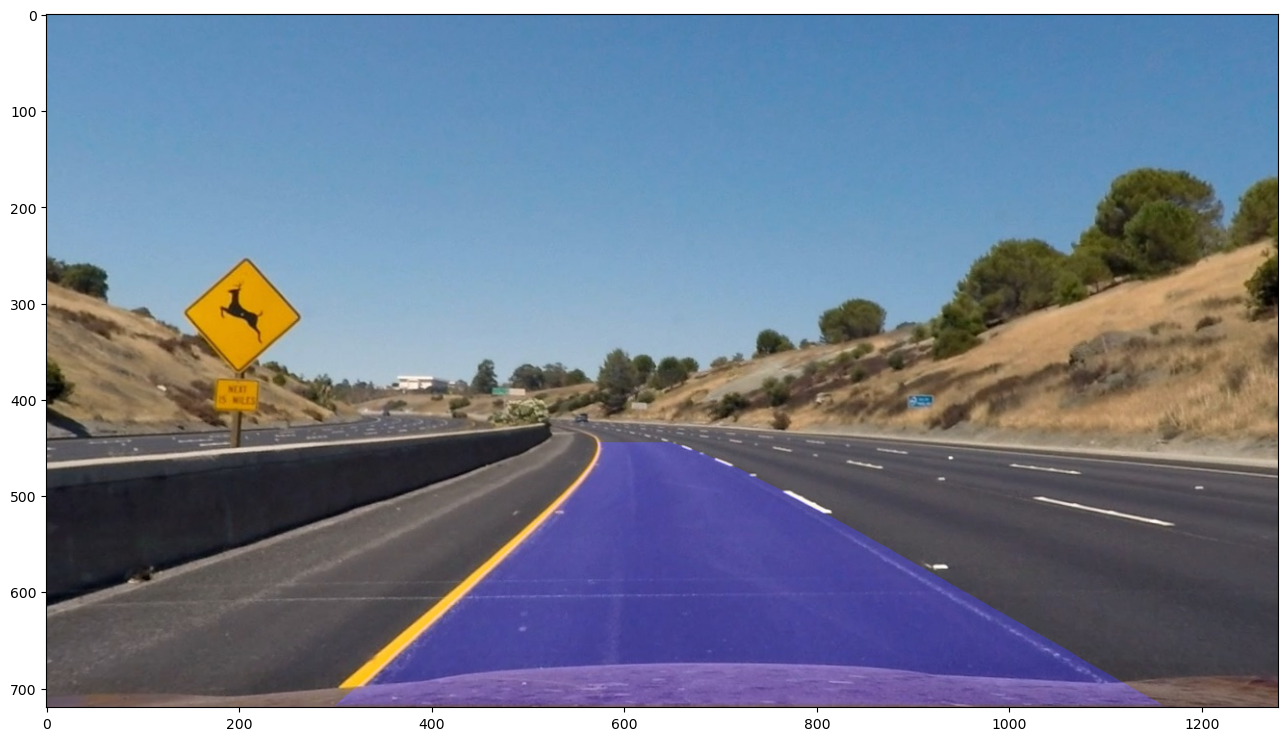

In [16]:
def project_back(wrap_img, origin_img, left_fitx, right_fitx, ploty, M):
    warp_zero = np.zeros_like(wrap_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 0, 255))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, M)
    # Combine the result with the original image
    result = cv2.addWeighted(origin_img, 1, newwarp, 0.3, 0)
    return result

M = cv2.getPerspectiveTransform(np.float32(dst_corners), np.float32(src_corners))
result = project_back(binary, test_img, left_fitx, right_fitx, ploty, M)
fig = plt.figure(figsize=(16, 9))
plt.imshow(result)